## O que é Aprendizagem por Transferência?
**As redes de aprendizagem profunda tendem a consumir muitos recursos e são computacionalmente caras**. Ao contrário dos modelos tradicionais de aprendizagem estatística (como regressão, árvores de decisão ou máquinas de vetores de suporte), elas tendem a conter milhões de parâmetros e, portanto, precisam de muitos dados de treinamento para evitar overfitting.

Portanto, os modelos de aprendizagem profunda são treinados com grandes quantidades de dados brutos de alta dimensão, como imagens, texto não estruturado ou sinais de áudio. Além disso, eles empregam milhões de computação vetorizada (por exemplo, multiplicação de matrizes) repetidamente para otimizar o enorme conjunto de parâmetros para se ajustar aos dados. Tudo isso leva a uma grande demanda no poder computacional necessário para treinar um modelo de aprendizagem profunda robusto e de alto desempenho para uma determinada tarefa.

Digamos que podemos treinar um ótimo modelo depois de gastar uma grande quantidade de recursos computacionais. Não queremos reutilizar esse modelo para o número máximo de tarefas e colher o benefício do nosso investimento muitas vezes?

> Mas aqui está o problema.

**Os algoritmos de aprendizagem profunda, até agora, foram tradicionalmente projetados para trabalhar de forma isolada**. Esses algoritmos são treinados para resolver tarefas específicas. Os modelos, na maioria dos casos, precisam ser reconstruídos do zero quando a distribuição do espaço de recursos muda.

> Mas isso não faz sentido, especialmente se comparado a como nós, humanos, utilizamos nossa velocidade de computação limitada.

**Os humanos têm uma capacidade inerente de transferir conhecimento entre tarefas**. O que adquirimos como conhecimento ao aprender sobre uma tarefa, utilizamos da mesma forma para resolver tarefas relacionadas. Se a similaridade entre as tarefas ou domínios for alta, somos capazes de utilizar melhor nosso conhecimento "aprendido".

> ***A aprendizagem por transferência é a ideia de superar o paradigma de aprendizagem isolada e utilizar o conhecimento adquirido para uma tarefa para resolver tarefas relacionadas, conforme aplicado ao aprendizado de máquina e, em particular, ao domínio do aprendizado profundo.***


![transfer-learning](https://raw.githubusercontent.com/frodriguesfajr/Imagens_DL/553ff3a8fa280275ed22b4e798c91ea955f0cd14/Transfer_learning.jpeg)

---

## Demonstração de Aprendizagem por Transferência com um exemplo simples

### Uma estratégia comum
Há uma infinidade de estratégias a serem seguidas para o processo de Aprendizagem por Transferência no cenário de Aprendizado Profundo, e várias coisas importantes a serem consideradas e decisões de engenharia a serem tomadas - similaridade de conjuntos de dados e domínios, cenário supervisionado ou não supervisionado, quanto retreinamento deve ser feito, etc.
No entanto, para simplificar, podemos assumir que para a aprendizagem de transferência,
- precisamos obter um modelo de Aprendizado Profundo pré-treinado,
- reutilizar tudo ou certas partes dele, e
- aplicá-lo ao nosso novo domínio de interesse, para um problema específico de aprendizagem de máquina - classificação ou regressão.

Dessa forma, podemos evitar uma grande parte do enorme esforço computacional de treinamento e otimização de um grande modelo de Aprendizado Profundo.

No final, um modelo de Aprendizado Profundotreinado é apenas uma coleção de milhões de números reais em um formato de estrutura de dados específico, que pode ser usado prontamente para previsão/inferência, a tarefa na qual estamos realmente interessados, como consumidores do modelo.

Mas lembre-se de que um modelo pré-treinado pode ter sido treinado usando uma classificação específica em mente, ou seja, seu vetor de saída e gráfico de computação são adequados para previsão de uma tarefa específica apenas.

Portanto, uma estratégia amplamente usada em aprendizagem de transferência é,

- carregar as matrizes de pesos de um modelo pré-treinado, exceto os pesos das últimas camadas próximas ao O/P,
- manter esses pesos fixos, ou seja, não treináveis
- anexar novas camadas adequadas para a tarefa em questão e treinar o modelo com novos dados

![TL-DL](https://raw.githubusercontent.com/frodriguesfajr/Imagens_DL/refs/heads/main/Transfer-learning-DL-1.jpeg)


### Esta demonstração
Demonstramos o conceito essencial de aprendizagem de transferência em um ambiente muito simples.

Pegamos o conhecido conjunto de dados CIFAR-10 e fazemos o seguinte,

- Crie uma rede neural Keras empilhando um conjunto de `classificiation_layers` em cima de um conjunto de `feature_layers`
- Treine a rede resultante em um conjunto de dados CIFAR-10 parcial, consistindo em exemplos das primeiras 5 categorias (0...4).
- Congele as `feature_layers` e empilhe um novo conjunto de camadas totalmente conectadas em cima delas, criando assim outra rede conv
- Treine esta nova rede conv nos exemplos do resto das categorias (5..9) do CIFAR-10, ajustando pesos apenas para aquelas camadas densamente conectadas


In [2]:
import sys
print('Versão python: ' + sys.version)

Versão python: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [3]:
import keras
print('Versão keras: ' + keras.__version__)

Versão keras: 3.5.0


In [4]:
import tensorflow as tf
print('Versão TensorFlow: ' + tf.__version__)
# Verifique as GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Ativar o crescimento de memória para a primeira GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)

        # (Opcional) Definir uma GPU específica, caso tenha mais de uma
        # tf.config.set_visible_devices(gpus[0], 'GPU')  # Descomente se necessário

        print("Configuração de GPU aplicada com sucesso!")
    except RuntimeError as e:
        print(f"Erro ao configurar a memória da GPU: {e}")
else:
    print("Nenhuma GPU disponível.")

Versão TensorFlow: 2.17.1
Configuração de GPU aplicada com sucesso!


In [5]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 47.2 MB/s eta 0:00:00



### Importar bibliotecas e funções

In [6]:
from __future__ import print_function

from time import time
from keras.datasets import mnist,cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K
import visualkeras

import matplotlib.pyplot as plt
import random

### Filtros, tamanho do pool e tamanho do kernel

In [7]:
# número de filtros convolucionais a usar
filters = 64
# tamanho da área de agrupamento para max pooling
pool_size = 2
# tamanho do kernel convolucional
kernel_size = 3

### Carregamento dos dados e divisão entre os conjuntos de treinamento e teste

In [8]:
(x_cifar_train, y_cifar_train), (x_cifar_test, y_cifar_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [9]:
y_cifar_train = y_cifar_train.reshape(50000,)
y_cifar_test = y_cifar_test.reshape(10000,)

### Criamos dois conjuntos de dados, um com rótulos de classe abaixo de 5 e outro com 5 ou mais



In [10]:
x_train_lt5 = x_cifar_train[y_cifar_train < 5]
y_train_lt5 = y_cifar_train[y_cifar_train < 5]
x_test_lt5 = x_cifar_test[y_cifar_test < 5]
y_test_lt5 = y_cifar_test[y_cifar_test < 5]

x_train_gte5 = x_cifar_train[y_cifar_train >= 5]
y_train_gte5 = y_cifar_train[y_cifar_train >= 5] - 5
x_test_gte5 = x_cifar_test[y_cifar_test >= 5]
y_test_gte5 = y_cifar_test[y_cifar_test >= 5] - 5

### Vamos ver alguns exemplos dos dois conjuntos de dados para entender o que está acontecendo.

Aqui está a descrição das categorias no conjunto de dados CIFAR-10,

![cifar-10](https://raw.githubusercontent.com/frodriguesfajr/Imagens_DL/refs/heads/main/CIFAR-10-categories.jpeg)

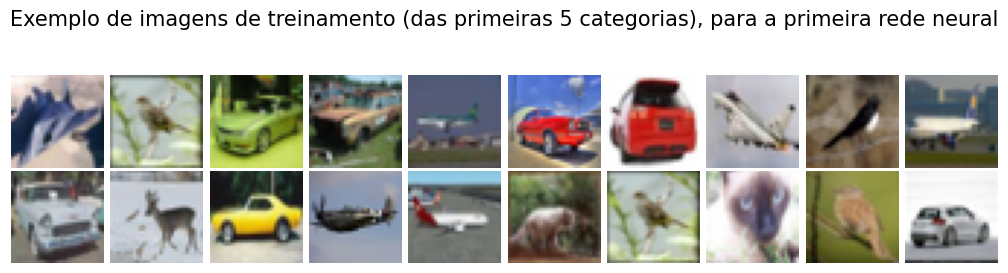

In [11]:
fig, ax = plt.subplots(2,10,figsize=(10,2.8))
fig.suptitle("Exemplo de imagens de treinamento (das primeiras 5 categorias), para a primeira rede neural\n", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_lt5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

Podemos executar a célula acima várias vezes, pegar índices aleatórios e mostrar as imagens, mas como estamos pegando imagens do conjunto de dados x_train_lt5, veremos apenas imagens de **avião, automóvel, pássaro, gato ou veado.**

E é isso que a rede neural também "verá".

No entanto, quando transferimos o aprendizado para uma nova rede neural, suas camadas de saída serão ajustadas em um novo conjunto de dados que consiste em imagens de **cachorro, sapo, cavalo, ovelha ou caminhão**.

Mas veremos que ele funcionará bem :-)

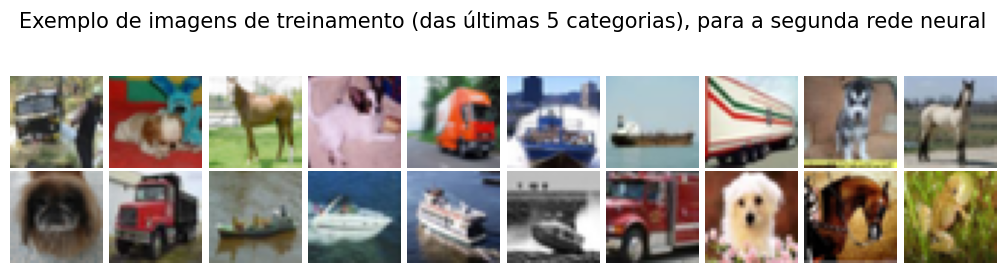

In [12]:
fig, ax = plt.subplots(2,10,figsize=(10,2.8))
fig.suptitle("Exemplo de imagens de treinamento (das últimas 5 categorias), para a segunda rede neural\n", fontsize=15)
axes = ax.ravel()
for i in range(20):
    # Pick a random number
    idx=random.randint(1,1000)
    axes[i].imshow(x_train_gte5[idx])
    axes[i].axis('off')
fig.tight_layout(pad=0.5)
plt.show()

### Defina o número de classes e o formato de entrada
---



In [13]:
num_classes = 5
input_shape = (32,32,3)

### Defina dois grupos de camadas: característica (convoluções) e classificação (densa)

In [14]:
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.25),
    Dense(num_classes),
    Activation('softmax')
]

### Crie o modelo completo empilhando conjuntamente`feature_layers` and `classification_layers`

In [16]:
model_1 = Sequential(feature_layers + classification_layers)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


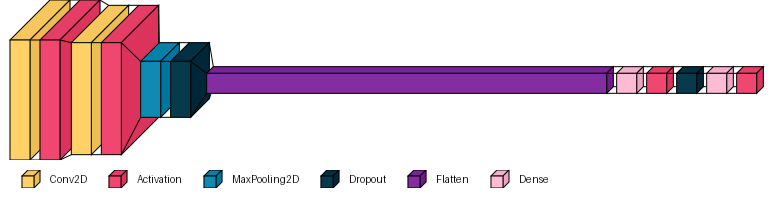

In [17]:
visualkeras.layered_view(model_1, legend=True) # without custom font

### Definição de função para treinar um modelo

In [18]:
def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    # model.compile(loss='categorical_crossentropy',
    #               optimizer=Adam(learning_rate=0.01),
    #               metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    t1 = time()
    history1 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    # history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    t2 = time()
    t_delta = round(t2-t1,2)
    print('Training time: {} seconds'.format(t_delta))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    return history1

### Batch size and epochs

In [19]:
batch_size = 128
epochs = 20

### Treinar o modelo para as 5 primeiras categorias de imagens

In [20]:
history2 = train_model(model_1,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.4881 - loss: 1.2394 - val_accuracy: 0.6636 - val_loss: 0.8391
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6692 - loss: 0.8306 - val_accuracy: 0.7148 - val_loss: 0.7373
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7230 - loss: 0.7165 - val_accuracy: 0.7070 - val_loss: 0.7317
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7543 - loss: 0.6359 - val_accuracy: 0.7596 - val_loss: 0.6391
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7852 - loss: 0.5673 - val_accuracy: 0.7582 - val_loss: 0.6282
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8176 - loss: 0.4905 - val_accuracy: 0.7686 - val_loss: 0.6069
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8335 - loss: 0.4445 - val_accuracy: 0.7708 - val_loss: 0.6175
Epoch 8/20
196/196 ━━━━

In [21]:
print(history2.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])



Observe o tempo gasto para esse treinamento. Isso vai variar dependendo do seu hardware, mas anote esse tempo.

### Mostre o resumo do modelo e observe que não há parâmetros não treináveis

In [22]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,935,377 (18.83 MB)

 Trainable params: 1,645,125 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,290,252 (12.55 MB)

### Evolução da Acurácia

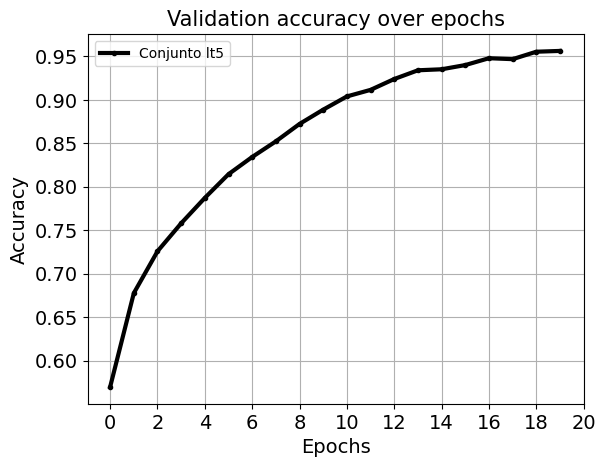

In [23]:
plt.title("Validation accuracy over epochs",fontsize=15)
plt.plot(history2.history['accuracy'],lw=3,c='k', label='Conjunto lt5', marker='.')
plt.grid(True)
plt.legend()
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Evolução da Loss

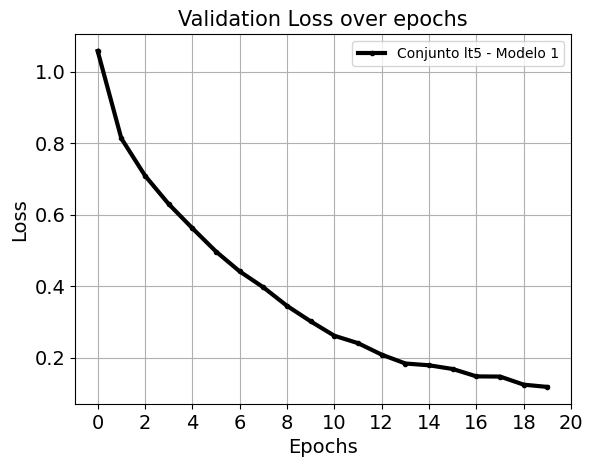

In [24]:
plt.title("Validation Loss over epochs",fontsize=15)
plt.plot(history2.history['loss'],lw=3,c='k', label='Conjunto lt5 - Modelo 1', marker='.')
plt.grid(True)
plt.legend()
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Congelar camadas de feições e reconstruir modelo
Esse congelamento de camadas de feições está no cerne do aprendizado de transferência. Isso permite a reutilização de modelos pré-treinados para tarefas de classificação, porque os usuários podem simplesmente empilhar novas camadas totalmente conectadas sobre as camadas de feições pré-treinadas e obter um bom desempenho.

Criaremos um novo modelo chamado `model_2` com `feature_layers` não treináveis ​​e `classification_layers` treináveis


In [25]:
for l in feature_layers:
    l.trainable = False

In [26]:
model_2 = Sequential(feature_layers + classification_layers)

### Mostre o resumo do modelo e veja que as camadas de recursos (Conv2D) foram renderizadas como não treináveis ​​agora

In [27]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,125 (6.28 MB)

 Trainable params: 1,606,405 (6.13 MB)

 Non-trainable params: 38,720 (151.25 KB)

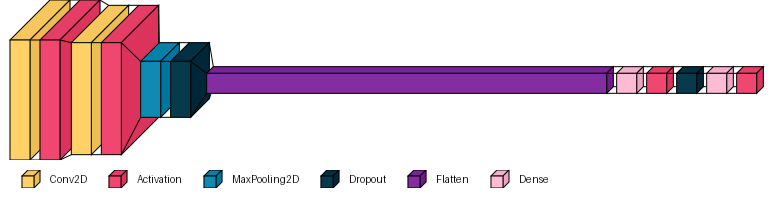

In [28]:
visualkeras.layered_view(model_2, legend=True) # without custom font

### Agora treine o modelo e veja como ele leva menos tempo no geral e ainda obtém desempenho igual ou superior (precisão de validação)

In [29]:
# transfer: treinar camadas densas para nova tarefa de classificação
history2a = train_model(model_2,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (25000, 32, 32, 3)
25000 train samples
5000 test samples
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.2991 - loss: 2.8259 - val_accuracy: 0.6966 - val_loss: 0.8613
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6488 - loss: 0.9046 - val_accuracy: 0.7808 - val_loss: 0.6112
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7443 - loss: 0.6851 - val_accuracy: 0.8100 - val_loss: 0.5284
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7895 - loss: 0.5640 - val_accuracy: 0.8230 - val_loss: 0.4859
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8137 - loss: 0.5000 - val_accuracy: 0.8354 - val_loss: 0.4687
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8286 - loss: 0.4552 - val_accuracy: 0.8432 - val_loss: 0.4545
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8542 - loss: 0.3985 - val_accuracy: 0.8442 - val_loss: 0.4397
Epoch 8/20
196/196 ━━━━━━━━━━━━

Observe que o tempo gasto foi reduzido.

Isso porque não treinamos as camadas Conv2D iniciais e apenas ajustamos as camadas totalmente conectadas.

A precisão permanece coerente.

In [30]:
print(history2a.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Plote acurácia

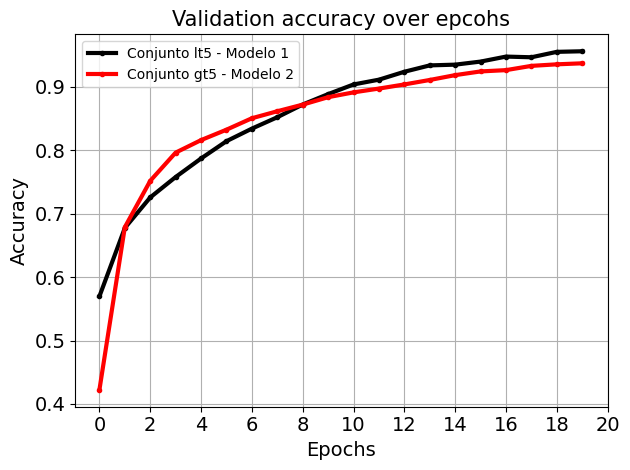

In [31]:
plt.title("Validation accuracy over epcohs",fontsize=15)
plt.plot(history2.history['accuracy'],lw=3,c='k', label='Conjunto lt5 - Modelo 1', marker='.')
plt.plot(history2a.history['accuracy'],lw=3,c='r', label='Conjunto gt5 - Modelo 2', marker='.')
plt.grid(True)
plt.legend()
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

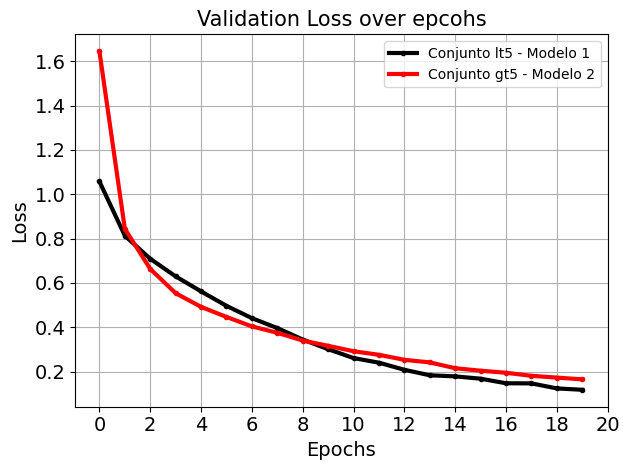

In [32]:
plt.title("Validation Loss over epcohs",fontsize=15)
plt.plot(history2.history['loss'],lw=3,c='k',  label='Conjunto lt5 - Modelo 1', marker='.')
plt.plot(history2a.history['loss'],lw=3,c='r', label='Conjunto gt5 - Modelo 2', marker='.')
plt.grid(True)
plt.legend()
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.xticks([2*i for i in range(11)],fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

### Tempo gasto pelos dois modelos para treinamento (número idêntico de epochs)

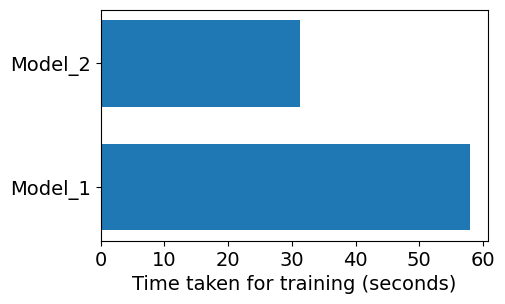

In [33]:
plt.figure(figsize=(5,3))
# plt.barh(y=['Model_1','Model_2'],width=[87,52],height=0.7)
plt.barh(y=['Model_1','Model_2'], width=[57.9,31.28], height=0.7)
plt.xlabel("Time taken for training (seconds)",fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()


## Resumo
O `model_2` foi inicializado como um novo modelo consistindo de camadas Conv2D não treináveis ​​e camadas totalmente conectadas treináveis. Os pesos das camadas Conv2D foram transferidos de um `model_1` previamente treinado.

O `model_2` não apenas treinou mais rápido que o `model_1`, mas também começou com uma precisão de linha de base mais alta e obteve melhor precisão final para o mesmo número de épocas e hiperparâmetros idênticos (taxa de aprendizado, otimizador, tamanho do lote, etc).

E obteve esse treinamento em imagens que não foram vistas pelo `model_1`. **Esta é a essência do aprendizado de transferência.**

Isso significa que, embora o `model_1` tenha sido treinado em imagens de - **avião, automóvel, pássaro, gato ou veado** - seus pesos aprendidos, quando transferidos para o `model_2`, ajudaram o `model_2` a obter excelente desempenho na classificação de categorias de imagens completamente diferentes - **cachorro, sapo, cavalo, ovelha ou caminhão**.


![two-categories](https://raw.githubusercontent.com/frodriguesfajr/Imagens_DL/refs/heads/main/transfer-learning-2-categories.jpeg)

